In [ ]:
import GPI_init_fit as gpi
import numpy as np
import matplotlib.pyplot as plt
import optimization.interpolated_univariate_spline as spline_func
from astropy.stats import bayesian_info_criterion as bic
from astropy.stats import akaike_info_criterion as aic

import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
from astropy.io import fits
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'
jax.config.update("jax_enable_x64", True)
import pandas as pd
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

In [20]:
### things to change ###
name = 'hd145560_H_pol'
disk_name = "HD145560"
num_knots = 6
########################

fits_image_filepath = "/home/blewis/GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]))
misc_params = Parameter_Index.misc_params

spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
disk_params = Parameter_Index.disk_params

image_data = pd.read_csv('image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "a_in", "a_out", "eccentricity", "ksi0", "gamma", "beta", "omega", "x_center", "y_center", "knots"]
row = image_data.loc[name]

disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]
misc_params['distance'] = row["Distance"]
spf_params['num_knots'] = num_knots
spf_params['knot_values'] = jnp.full(spf_params['num_knots'],0.5)
disk_params['alpha_in'] = row['a_in']
disk_params['alpha_out'] = row['a_out']
disk_params['e'] = row['eccentricity']
disk_params['ksi0'] = row['ksi0']
disk_params['gamma'] = row['gamma']
disk_params['beta'] = row['beta']
disk_params['omega'] = row['omega']
disk_params['x_center'] = 70
disk_params['y_center'] = 70

41.5


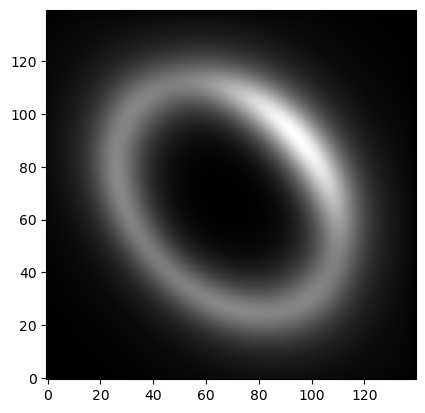

In [32]:
spf_params['knot_values'] = [1,0.5,0.5,0.5,0.5,0]
disk_params['position_angle'] = 41.5
print(disk_params['position_angle'])

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

plt.imshow(img,origin='lower', cmap='gray')

In [11]:
opt = Optimizer(disk_params, spf_params, psf_params, misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)
opt.name = disk_name
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']
array_params = ['knot_values']
logscaled_params = []
opt.inc_bound_knots()
opt.scale_initial_knots(target_image)

##initial minimization

soln = opt.scipy_optimize(fit_keys, logscaled_params, array_params, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
opt.save_human_readable('../GPI_results')
opt.save_machine_readable('../GPI_results')

##bounded minimization

bounds = ([0.01, -45,   0, 0,0.01, 0.01,-15,-20,   0, -20, 60,  60,    0, np.zeros(num_knots)],
          [45, -0.01, 150, 1, 200,  200, 15,380, 180, 380, 90,  90,  5e6, 1e4*np.ones(num_knots)])

#soln = opt.scipy_bounded_optimize(fit_keys, bounds, logscaled_params, array_params, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
#opt.save_human_readable('../GPI_results')
#opt.save_machine_readable('../GPI_results')

optimal_image = opt.model()
optimal_ll = opt.log_likelihood(target_image,err_map)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/blewis/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3162713/492537948.py", line 12, in <module>
    soln = opt.scipy_optimize(fit_keys, logscaled_params, array_params, target_image, err_map, disp_soln=True,iters = 1000)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/blewis/GRaTeR-JAX/optimization/optimize_framework.py", line 48, in scipy_optimize
    soln = minimize(llp, init_x, method=method, options={'disp': True, 'max_itr': iters})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/blewis/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py", line 708, in minimize
    res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
          ^^^^^^^^^^^^^^

In [ ]:
opt.disk_params['x_center'] = 200
opt.print_params()
opt.load_machine_readable('../GPI_results')
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5.282975438111148, 'alpha_out': -2.692451126271068, 'sma': 80.24237022624686, 'e': 0.012111821238527734, 'ksi0': 2.8568214807468926, 'gamma': 74.22547279378412, 'beta': 0.33013907351992355, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 44.32203878002903, 'position_angle': 221.51062101231958, 'x_center': 200, 'y_center': 72.28877699020366, 'halfNbSlices': 25, 'omega': -1.7634081734937395}
SPF Params: {'backscatt_bound': -1, 'forwardscatt_bound': Array(0.69340183, dtype=float64), 'num_knots': 6, 'knot_values': Array([1.79676916e+00, 1.37175432e+00, 1.02443759e+00, 4.42070332e-01,
       1.61812025e-01, 2.52825219e-09], dtype=float64), 'low_bound': Array(-0.69340183, dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 120.44, 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': Array(1455.47664395, dtype=float64)}
Loaded machine readable files from json in ../GPI_results
Disk Param

In [ ]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5.282975438111148, 'alpha_out': -2.692451126271068, 'sma': 80.24237022624686, 'e': 0.012111821238527734, 'ksi0': 2.8568214807468926, 'gamma': 74.22547279378412, 'beta': 0.33013907351992355, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 44.32203878002903, 'position_angle': 221.51062101231958, 'x_center': 72.99818103452631, 'y_center': 72.28877699020366, 'halfNbSlices': 25, 'omega': -1.7634081734937395}
SPF Params: {'backscatt_bound': -1, 'forwardscatt_bound': 0.693401828275813, 'num_knots': 6, 'knot_values': Array([1.79676916e+00, 1.37175432e+00, 1.02443759e+00, 4.42070332e-01,
       1.61812025e-01, 2.52825219e-09], dtype=float64), 'low_bound': -0.6934018282758131}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 120.44, 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': 1455.476643954776}


In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 5)
vmax = np.nanpercentile(target_image[mask], 95)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

mask_circle1 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle2 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle3 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[0].add_artist(mask_circle1)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("Initial Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[1].add_artist(mask_circle2)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=10)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
axes[2].add_artist(mask_circle3)
plt.savefig('../GPI_results/{}_scipyboundminimize_fit.png'.format(disk_name))

In [ ]:
spf1 = opt.spf_params

lo = np.rad2deg(np.arccos(spf1['backscatt_bound']))
up = np.rad2deg(np.arccos(spf1['forwardscatt_bound']))
print(up,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(up,lo,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func,label='Interpolation')
plt.scatter(np.linspace(up,lo,num_knots),spf1['knot_values'],color='orange',label='Knots')
ax = plt.gca()
ax.axvspan(lo,180,alpha=0.5,color='grey',hatch='/')
ax.axvspan(0,up,alpha=0.5,color='grey',hatch='/')

###CHANGE NAMES
plt.title('{} Pol SPF Initial Fit ({} knots)'.format(disk_name, num_knots))
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.legend()
plt.xlim(0,180)
plt.ylim(-0.1,10)
plt.savefig('../GPI_results/best_fits/{}_scipyboundminimize_pol_spf.png'.format(disk_name),bbox_inches='tight')

In [ ]:
##important! number of steps, continue from

mc_model = opt.mcmc(fit_keys, logscaled_params, array_params,target_image, err_map, bounds, nwalkers=100, niter=4600, burns=20, continue_from=True)

In [ ]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()
opt.print_params()
samples = mc_model.sampler.get_chain()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

mask_circle1 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle2 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle3 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].add_artist(mask_circle1)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("MCMC Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[1].add_artist(mask_circle2)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[2].add_artist(mask_circle3)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_MCMC_fit.png'.format(disk_name))

In [ ]:
spf1 = opt.spf_params

hi = np.rad2deg(np.arccos(spf1['backscatt_bound']))
lo = np.rad2deg(np.arccos(spf1['forwardscatt_bound']))
print(hi,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func,label='Interpolation')
plt.scatter(np.linspace(lo,hi,num_knots),spf1['knot_values'],color='orange',label='Knots')
ax = plt.gca()
ax.axvspan(hi,180,alpha=0.5,color='grey',hatch='/')
ax.axvspan(0,lo,alpha=0.5,color='grey',hatch='/')

###CHANGE NAMES
plt.title('{} Pol SPF Initial Fit ({} knots)'.format(disk_name, num_knots))
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.legend()
plt.xlim(0,180)
plt.ylim(-0.1,10)
plt.savefig('../GPI_results/best_fits/{}_MCMC_pol_spf.png'.format(disk_name),bbox_inches='tight')

In [ ]:
labels = '$\\alpha_{in}$', '$\\alpha_{out}$', 'Semimajor Axis', 'Eccentricity', '$\\xi__0$', '$\\gamma$', '$\\beta$', '$\\omega$', '$i$', 'PA', 'x$_{c}$', 'y$_{c}$', 'Flux Scaling']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('Knot '+str(i+1))
mc_model.plot_chains(labels)
plt.savefig('../GPI_results/{}_MCMC_chains.png'.format(disk_name),bbox_inches='tight')

In [ ]:
mc_model.show_corner_plot(labels, truths=mc_soln)
plt.savefig('../GPI_results/{}_MCMC_corner.png'.format(disk_name),bbox_inches='tight')

In [ ]:
mc_model.sampler.get_autocorr_time()